In [ ]:

# ===========================================================================
# 1. Import the Necessary Libraries
# ===========================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


In [ ]:

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

# ===========================================================================
# 2. Load the Dataset Using kagglehub
# ===========================================================================
import kagglehub
import pandas as pd
import os

# Download the latest version of the dataset
path = kagglehub.dataset_download("pashupatigupta/emotion-detection-from-text")
print("Path to dataset files:", path)

# List files in the downloaded directory to find the CSV
dataset_dir = path
csv_files = [f for f in os.listdir(dataset_dir) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV files found in the downloaded dataset directory.")
csv_file = os.path.join(dataset_dir, csv_files[0])  # Assume the first CSV is the target file
print("Using CSV file:", csv_file)

# Load the dataset into a pandas DataFrame
df = pd.read_csv(csv_file)

# Display dataset information
print("\nDataset Preview:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nUnique Sentiments:", df['sentiment'].nunique())
print("Sample Size:", len(df))


Path to dataset files: /root/.cache/kagglehub/datasets/pashupatigupta/emotion-detection-from-text/versions/1
Using CSV file: /root/.cache/kagglehub/datasets/pashupatigupta/emotion-detection-from-text/versions/1/tweet_emotions.csv

Dataset Preview:
     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   conten

In [ ]:

# ===========================================================================
# 3. Data Cleaning
# ===========================================================================
# Drop rows with missing values
df = df.dropna(subset=['content', 'sentiment'])
print("\nMissing Values After Cleaning:\n")
print(df.isnull().sum())

# Map sentiments to numerical labels
emotion_mapping = {label: idx for idx, label in enumerate(df['sentiment'].unique())}
df['emotion_label'] = df['sentiment'].map(emotion_mapping)
print("\nEmotion Mapping:", emotion_mapping)



Missing Values After Cleaning:

tweet_id     0
sentiment    0
content      0
dtype: int64

Emotion Mapping: {'empty': 0, 'sadness': 1, 'enthusiasm': 2, 'neutral': 3, 'worry': 4, 'surprise': 5, 'love': 6, 'fun': 7, 'hate': 8, 'happiness': 9, 'boredom': 10, 'relief': 11, 'anger': 12}


In [ ]:

# ===========================================================================
# 4. Data Preprocessing
# ===========================================================================
# Define stop words and preprocessing function
import nltk
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing
df['cleaned_text'] = df['content'].apply(preprocess_text)

# Calculate text length for analysis
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))

# Define features and target
X = df['cleaned_text']
y = df['emotion_label']

# Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=1500, min_df=2)  # Increased features, minimum document frequency
X_tfidf = tfidf.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
print("\nTraining Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



Training Set Shape: (32000, 1500)
Testing Set Shape: (8000, 1500)


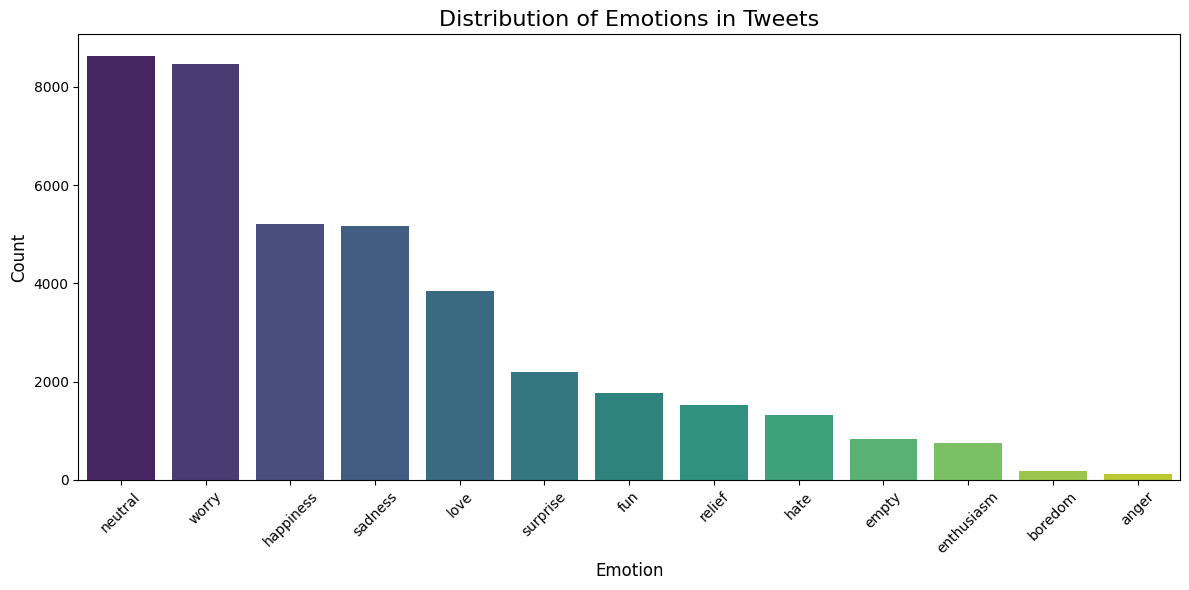

In [ ]:

# ===========================================================================
# 5. Visualizations
# ===========================================================================
# 5.1 Emotion Distribution Bar Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index, palette='viridis')
plt.title('Distribution of Emotions in Tweets', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


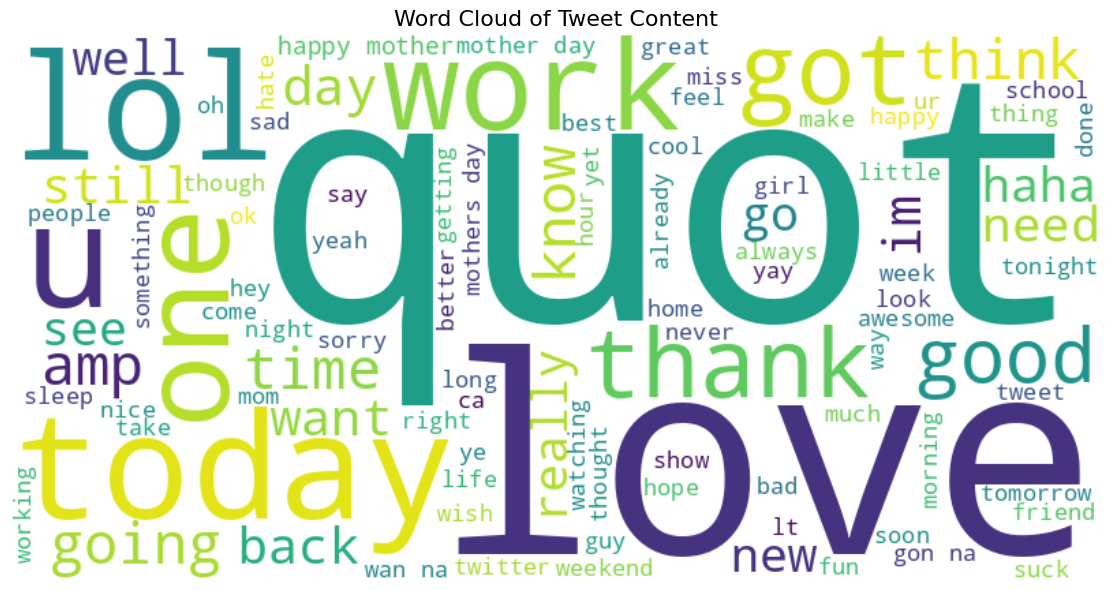

In [ ]:

# 5.2 Word Cloud for Most Frequent Words
all_text = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Tweet Content', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()


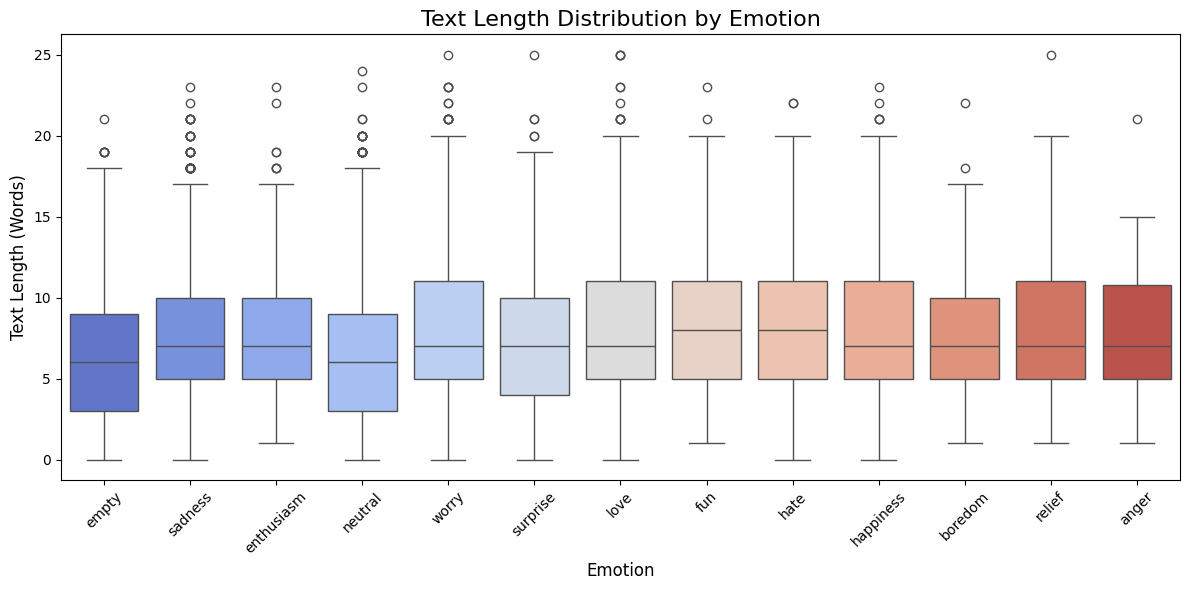

In [ ]:

# 5.3 Text Length Distribution by Emotion
plt.figure(figsize=(12, 6))
sns.boxplot(x='sentiment', y='text_length', data=df, palette='coolwarm')
plt.title('Text Length Distribution by Emotion', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Text Length (Words)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [39]:
# ==========================================================================
# 6. Model Building (Optimized for Speed & Accuracy)
# ==========================================================================

# Ensure necessary libraries are imported
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# Define stopwords and preprocessing function
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_tokens)

# Apply preprocessing
df['cleaned_text'] = df['content'].apply(preprocess_text)

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=3000, min_df=2)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['emotion_label']

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define faster models with good accuracy
models = {
    'Naive Bayes': MultinomialNB(),
    'Ridge Classifier': RidgeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=150, random_state=42)
}

# Train models and store predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict(X_test)
    print(f"\n{name} Training Complete")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Naive Bayes Training Complete

Ridge Classifier Training Complete

Gradient Boosting Training Complete

Extra Trees Training Complete


In [40]:

# ===========================================================================
# 7. Model Evaluation
# ===========================================================================
# Evaluate each model
accuracies = {}
for name, y_pred in predictions.items():
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy
    print(f"\n--- {name} Evaluation ---")
    print(f"Accuracy Score: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=emotion_mapping.keys(), zero_division=0))



--- Naive Bayes Evaluation ---
Accuracy Score: 0.4758

Classification Report:
              precision    recall  f1-score   support

       empty       0.47      0.54      0.50      1727
     sadness       0.35      0.29      0.32      1728
  enthusiasm       0.46      0.57      0.51      1728
     neutral       0.18      0.11      0.13      1728
       worry       0.28      0.18      0.22      1728
    surprise       0.38      0.32      0.34      1727
        love       0.48      0.45      0.46      1728
         fun       0.45      0.46      0.46      1728
        hate       0.59      0.59      0.59      1727
   happiness       0.33      0.29      0.31      1727
     boredom       0.63      0.98      0.77      1728
      relief       0.45      0.46      0.46      1727
       anger       0.73      0.96      0.83      1728

    accuracy                           0.48     22459
   macro avg       0.44      0.48      0.45     22459
weighted avg       0.44      0.48      0.45     22459



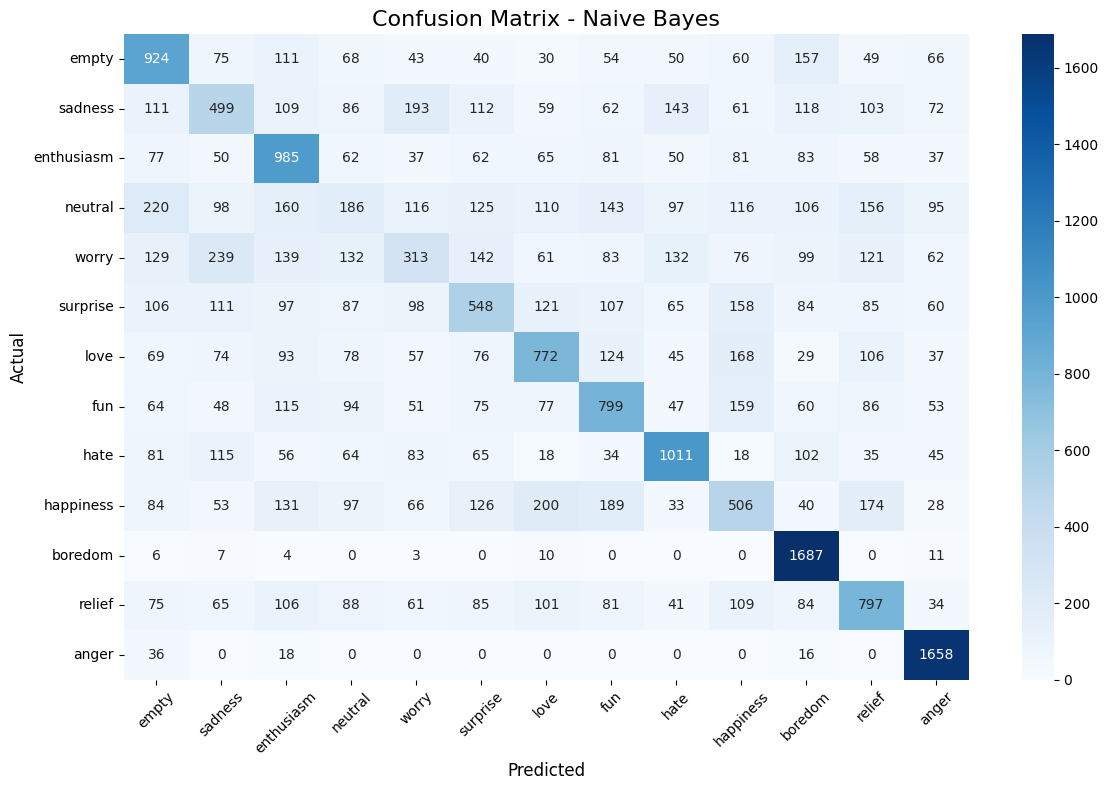

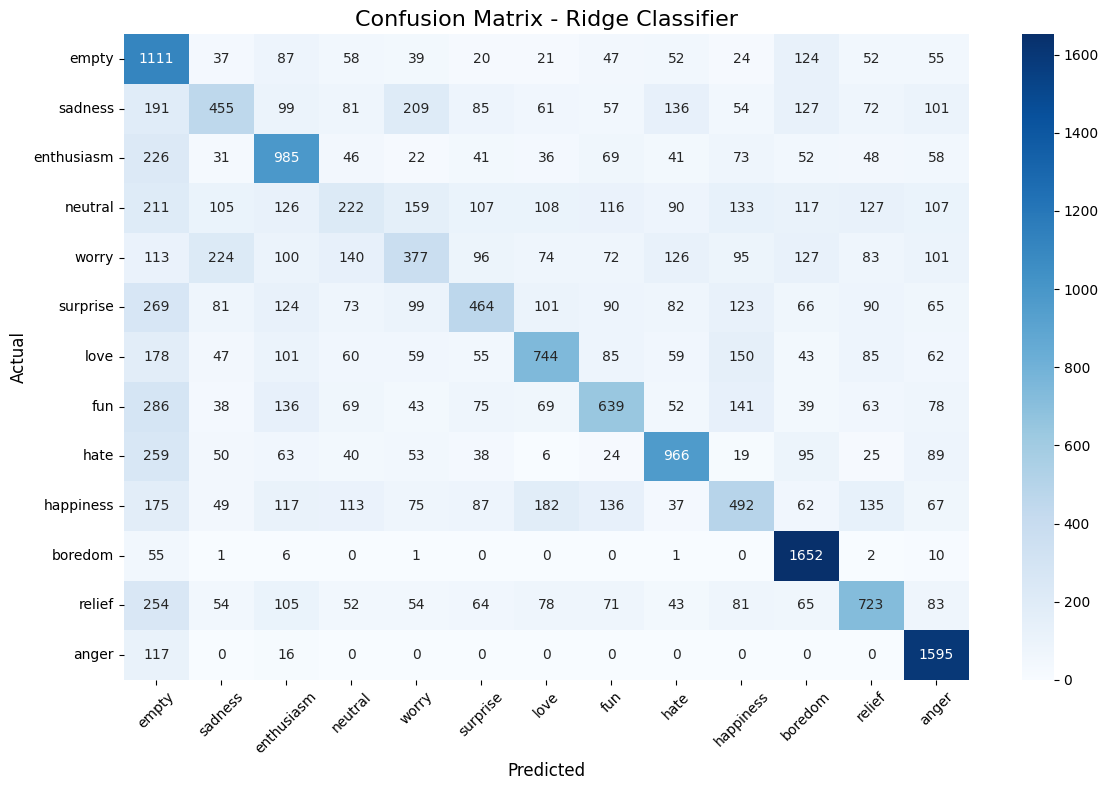

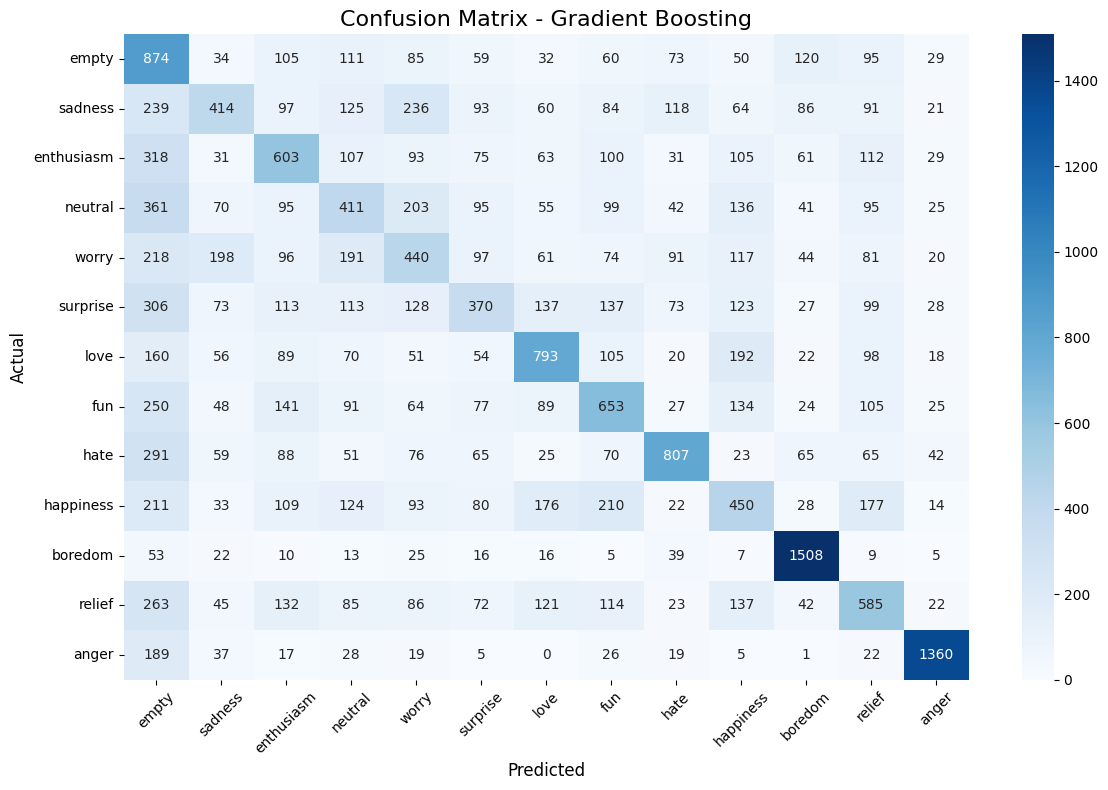

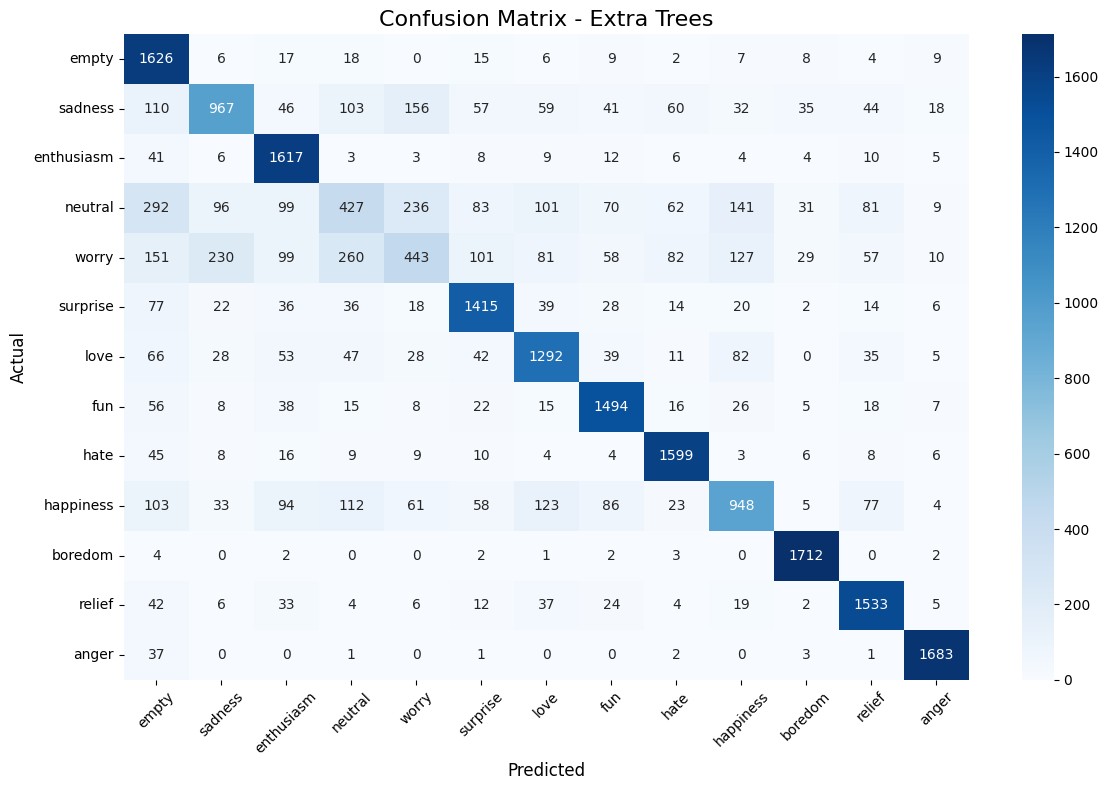

In [42]:

# ===========================================================================
# 8. Enhanced Visualizations
# ===========================================================================
# 8.1 Confusion Matrix for Each Model
for name, y_pred in predictions.items():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=emotion_mapping.keys(), yticklabels=emotion_mapping.keys(), cmap='Blues')
    plt.title(f'Confusion Matrix - {name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


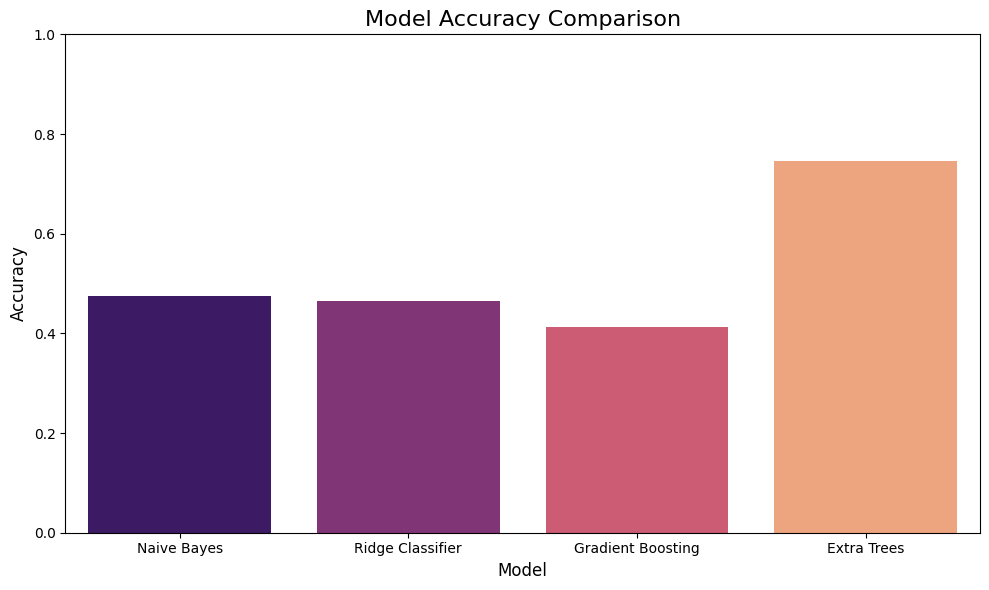

In [43]:

# 8.2 Model Accuracy Comparison Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='magma')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


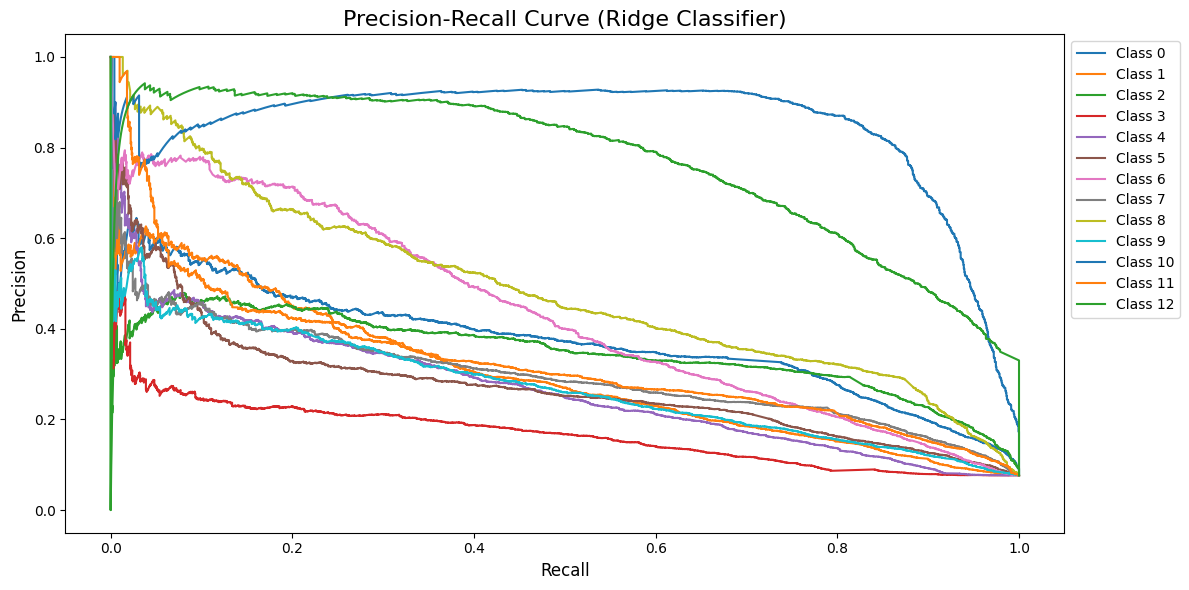

In [44]:

# 8.3 Precision-Recall Curve for Ridge Classifier
plt.figure(figsize=(12, 6))
y_scores = models['Ridge Classifier'].decision_function(X_test)
for i in range(y_scores.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test == i, y_scores[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
plt.title('Precision-Recall Curve (Ridge Classifier)', fontsize=16)
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


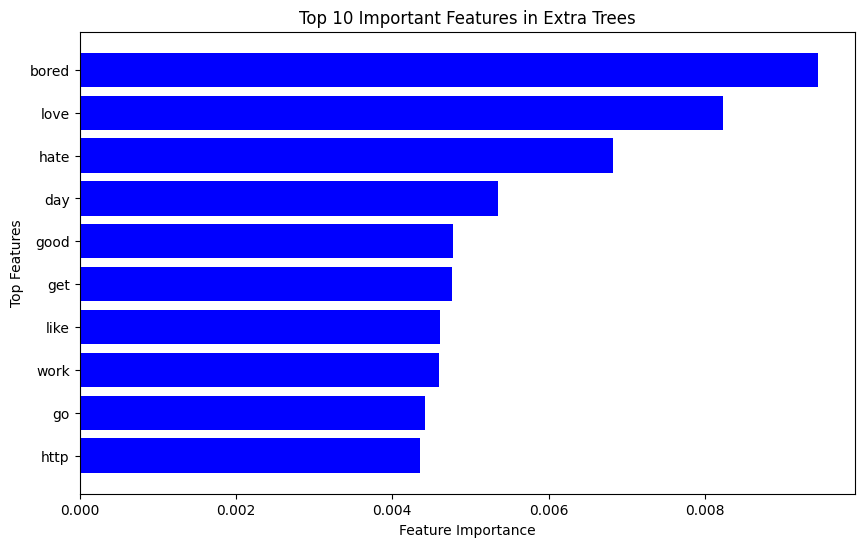

In [45]:

# 8.4 Feature Importance for Extra Trees (Top 10)
feature_importance = models['Extra Trees'].feature_importances_
top_indices = np.argsort(feature_importance)[-10:]
top_features = [tfidf.get_feature_names_out()[i] for i in top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, feature_importance[top_indices], color='blue')
plt.xlabel("Feature Importance")
plt.ylabel("Top Features")
plt.title("Top 10 Important Features in Extra Trees")
plt.show()

In [46]:

# ===========================================================================
# 9. r2_score (Accuracy as Substitute)
# ===========================================================================
print("\nFinal Model Accuracies (Substitute for r2_score):")
for name, accuracy in accuracies.items():
    print(f"{name}: {accuracy:.4f}")



Final Model Accuracies (Substitute for r2_score):
Naive Bayes: 0.4758
Ridge Classifier: 0.4642
Gradient Boosting: 0.4127
Extra Trees: 0.7461
